In [231]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt

In [232]:
maxAcc = 0.0
maxIter = 0
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
# M = 10
C_Lambda = 0.05
PHI = []
IsSynthetic = False
M = [x for x in range(1,50,2)]
#C_Lambda = [x/100 for x in range(0,100,4)]
TrainingERMS = []
ValidationERMS = []
TestERMS = []
#print(M)

In [233]:
def GetTargetVector(filePath):
    t = []
    with open(filePath, 'rU') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[0]))
    print("Raw Training Generated..")
    return t

def GenerateRawData(filePath, IsSynthetic):    
    dataMatrix = [] 
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column))
            dataMatrix.append(dataRow)   
    
    if IsSynthetic == False :
        dataMatrix = np.delete(dataMatrix, [5,6,7,8,9], axis=1)
    dataMatrix = np.transpose(dataMatrix)     
    print ("Data Matrix Generated..")
    print ("Data Matrix 0 = ",dataMatrix[1])
    return dataMatrix

def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    print(str(TrainingPercent) + "% Training Target Generated..")
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t = rawData[TrainingCount+1:V_End]
    print (str(ValPercent) + "% Val Target Data Generated..")
    return t

def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    print ("BigSigma Generated..")
    return BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Matrix Generated..")
    return PHI

def GetWeightsClosedForm(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    print ("Training Weights Generated..")
    return W

def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    #print ("Test Out Generated..")
    return Y

def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    print ("Accuracy Generated..")
    print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

## Fetch and Prepare Dataset

In [234]:
RawTarget = GetTargetVector('Querylevelnorm_t.csv')
RawData   = GenerateRawData('Querylevelnorm_X.csv',IsSynthetic)

C:\Users\Parth\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Parth\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: 'U' mode is deprecated
  if sys.path[0] == '':


Raw Training Generated..
Data Matrix Generated..
Data Matrix 0 =  [0.      0.66667 0.16667 ... 0.33333 1.      0.33333]


## Prepare Training Data

In [235]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print("TrainingTarget.shape = ",TrainingTarget.shape)
print("TrainingData.shape = ",TrainingData.shape)

80% Training Target Generated..
80% Training Data Generated..
TrainingTarget.shape =  (55699,)
TrainingData.shape =  (41, 55699)


## Prepare Validation Data

In [236]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

10% Val Target Data Generated..
10% Val Data Generated..
(6962,)
(41, 6962)


## Prepare Test Data

In [237]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print("TestDataAct.shape = ",TestDataAct.shape)
print("TestData.shape = ",TestData.shape)

10% Val Target Data Generated..
10% Val Data Generated..
TestDataAct.shape =  (6961,)
TestData.shape =  (41, 6961)


## Printing Headers

In [238]:
print ('UBITname      = parthnay')
print ('Person Number = 50291125')
print ('----------------------------------------------------')
print ("------------------LeToR Data------------------------")
print ('----------------------------------------------------')
print ("-------Closed Form with Radial Basis Function-------")
print ('----------------------------------------------------')

UBITname      = parthnay
Person Number = 50291125
----------------------------------------------------
------------------LeToR Data------------------------
----------------------------------------------------
-------Closed Form with Radial Basis Function-------
----------------------------------------------------


## Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]

BigSigma Generated..
Training Weights Generated..
Accuracy Generated..
Validation E_RMS : 0.5651378688420825
Accuracy Generated..
Validation E_RMS : 0.5543829470564674
Accuracy Generated..
Validation E_RMS : 0.6402356443936524
BigSigma Generated..
Training Weights Generated..
Accuracy Generated..
Validation E_RMS : 0.5532657345693542
Accuracy Generated..
Validation E_RMS : 0.5415075372654637
Accuracy Generated..
Validation E_RMS : 0.6317820612440738
BigSigma Generated..
Training Weights Generated..
Accuracy Generated..
Validation E_RMS : 0.552832498447951
Accuracy Generated..
Validation E_RMS : 0.5410870747606484
Accuracy Generated..
Validation E_RMS : 0.6311316347717641
BigSigma Generated..
Training Weights Generated..
Accuracy Generated..
Validation E_RMS : 0.5512043224615857
Accuracy Generated..
Validation E_RMS : 0.5405179439184792
Accuracy Generated..
Validation E_RMS : 0.6288648425256055
BigSigma Generated..
Training Weights Generated..
Accuracy Generated..
Validation E_RMS : 0.5

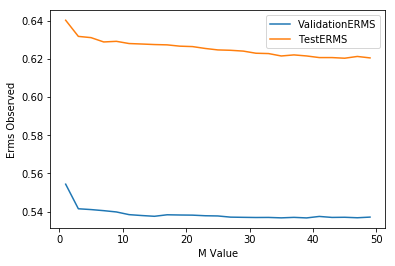

Best TrainingERMS =  0.5410855742370273
Best ValidationERMS =  0.5367186897442348
Best TestERMS =  0.6203480316948987


In [239]:
ErmsArr = []
AccuracyArr = []

for i in range(len(M)):
    kmeans = KMeans(n_clusters=M[i], random_state=0).fit(np.transpose(TrainingData))
    #kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
    Mu = kmeans.cluster_centers_

    BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
    TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
    #W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda[i]))
    W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
    TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
    VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)
#     print("Mu.shape = ",Mu.shape)
#     print("BigSigma.shape = ",BigSigma.shape)
#     print("TRAINING_PHI.shape = ",TRAINING_PHI.shape)
#     print("W.shape = ",W.shape)
#     print("VAL_PHI.shape = ",VAL_PHI.shape)
#     print("TEST_PHI.shape = ",TEST_PHI.shape)
    TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
    VAL_TEST_OUT = GetValTest(VAL_PHI,W)
    TEST_OUT     = GetValTest(TEST_PHI,W)

    TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
    ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
    TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))
    TrainingERMS.append(float(TrainingAccuracy.split(',')[1]))
    ValidationERMS.append(float(ValidationAccuracy.split(',')[1]))
    TestERMS.append(float(TestAccuracy.split(',')[1]))
#     print ("M = ", M[i])
#     print ("lambda = ", C_Lambda)
#     print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
#     print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
#     print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))
#     print ()
print("ValidationERMS = ",ValidationERMS)
print("TestERMS = ",TestERMS)
plt.plot(M,ValidationERMS,label="ValidationERMS")
plt.plot(M,TestERMS,label="TestERMS")
plt.xlabel("M Value")
plt.ylabel("Erms Observed")
plt.legend()
plt.show()
print("Best TrainingERMS = ",str(min(TrainingERMS)))
print("Best ValidationERMS = ",str(min(ValidationERMS)))
print("Best TestERMS = ",str(min(TestERMS)))

In [240]:
print ('UBITname      = parthnay')
print ('Person Number = 50291125')
print ('----------------------------------------------------')
print ("------------------LeToR Data------------------------")
print ('----------------------------------------------------')
print ("-------Closed Form with Radial Basis Function-------")
print ('----------------------------------------------------')

UBITname      = parthnay
Person Number = 50291125
----------------------------------------------------
------------------LeToR Data------------------------
----------------------------------------------------
-------Closed Form with Radial Basis Function-------
----------------------------------------------------


## Gradient Descent solution for Linear Regression

In [241]:
print ('----------------------------------------------------')
print ('--------------Please Wait for 2 mins!----------------')
print ('----------------------------------------------------')

----------------------------------------------------
--------------Please Wait for 2 mins!----------------
----------------------------------------------------


In [242]:
W_Now        = np.dot(220, W)
La           = 2
learningRate = 0.01
#learningRate = [x/100 for x in range(1,100,4)]
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

for i in range(0,400):
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

Accuracy Generated..
Validation E_RMS : 68.76120039003027
Accuracy Generated..
Validation E_RMS : 68.99301163551931
Accuracy Generated..
Validation E_RMS : 69.51020576204817
Accuracy Generated..
Validation E_RMS : 40.34342108657074
Accuracy Generated..
Validation E_RMS : 40.321514955130056
Accuracy Generated..
Validation E_RMS : 40.84140717434526
Accuracy Generated..
Validation E_RMS : 32.37476364366713
Accuracy Generated..
Validation E_RMS : 32.101891748161655
Accuracy Generated..
Validation E_RMS : 32.48595063387086
Accuracy Generated..
Validation E_RMS : 35.320191115774264
Accuracy Generated..
Validation E_RMS : 34.836334593915126
Accuracy Generated..
Validation E_RMS : 34.90645190608624
Accuracy Generated..
Validation E_RMS : 33.57747766042414
Accuracy Generated..
Validation E_RMS : 33.11708182317839
Accuracy Generated..
Validation E_RMS : 33.221702163501234
Accuracy Generated..
Validation E_RMS : 37.802123576824386
Accuracy Generated..
Validation E_RMS : 37.3115829635858
Accuracy 

Accuracy Generated..
Validation E_RMS : 16.043064636059707
Accuracy Generated..
Validation E_RMS : 21.564918581443376
Accuracy Generated..
Validation E_RMS : 21.64528123948937
Accuracy Generated..
Validation E_RMS : 21.800753946805543
Accuracy Generated..
Validation E_RMS : 18.954526876217418
Accuracy Generated..
Validation E_RMS : 19.014769620174903
Accuracy Generated..
Validation E_RMS : 19.17111099443986
Accuracy Generated..
Validation E_RMS : 16.665460678441942
Accuracy Generated..
Validation E_RMS : 16.70226000288416
Accuracy Generated..
Validation E_RMS : 16.85812190684752
Accuracy Generated..
Validation E_RMS : 15.629526633064028
Accuracy Generated..
Validation E_RMS : 15.65569012856414
Accuracy Generated..
Validation E_RMS : 15.808113240311743
Accuracy Generated..
Validation E_RMS : 12.682760977978694
Accuracy Generated..
Validation E_RMS : 12.646109062354556
Accuracy Generated..
Validation E_RMS : 12.79023305714682
Accuracy Generated..
Validation E_RMS : 11.464199574406218
Acc

Accuracy Generated..
Validation E_RMS : 5.934604372964129
Accuracy Generated..
Validation E_RMS : 5.954718139494435
Accuracy Generated..
Validation E_RMS : 5.984984857165101
Accuracy Generated..
Validation E_RMS : 5.2280515873033
Accuracy Generated..
Validation E_RMS : 5.233647334872786
Accuracy Generated..
Validation E_RMS : 5.26843040514997
Accuracy Generated..
Validation E_RMS : 5.070405904075752
Accuracy Generated..
Validation E_RMS : 5.074703618933625
Accuracy Generated..
Validation E_RMS : 5.108717402932789
Accuracy Generated..
Validation E_RMS : 5.03891917431823
Accuracy Generated..
Validation E_RMS : 5.046088193184487
Accuracy Generated..
Validation E_RMS : 5.077781218624123
Accuracy Generated..
Validation E_RMS : 5.3679512035148305
Accuracy Generated..
Validation E_RMS : 5.386500087805409
Accuracy Generated..
Validation E_RMS : 5.411714631552408
Accuracy Generated..
Validation E_RMS : 4.767686379982783
Accuracy Generated..
Validation E_RMS : 4.773276448031922
Accuracy Generate

Accuracy Generated..
Validation E_RMS : 2.893501786747396
Accuracy Generated..
Validation E_RMS : 2.867257746623626
Accuracy Generated..
Validation E_RMS : 2.9243701237506214
Accuracy Generated..
Validation E_RMS : 2.802547187529902
Accuracy Generated..
Validation E_RMS : 2.7771638434264845
Accuracy Generated..
Validation E_RMS : 2.834786178016338
Accuracy Generated..
Validation E_RMS : 2.2461429420157213
Accuracy Generated..
Validation E_RMS : 2.2265223406108783
Accuracy Generated..
Validation E_RMS : 2.2815963813687405
Accuracy Generated..
Validation E_RMS : 1.9895370970084352
Accuracy Generated..
Validation E_RMS : 1.9748103355088662
Accuracy Generated..
Validation E_RMS : 2.0264131435608674
Accuracy Generated..
Validation E_RMS : 1.70312959930395
Accuracy Generated..
Validation E_RMS : 1.7008227692831037
Accuracy Generated..
Validation E_RMS : 1.737952738632332
Accuracy Generated..
Validation E_RMS : 1.6646243600348414
Accuracy Generated..
Validation E_RMS : 1.673896533318954
Accur

Accuracy Generated..
Validation E_RMS : 0.9042265334094894
Accuracy Generated..
Validation E_RMS : 0.9028822014532638
Accuracy Generated..
Validation E_RMS : 0.9812477319138853
Accuracy Generated..
Validation E_RMS : 0.8084591961713615
Accuracy Generated..
Validation E_RMS : 0.8122372156549669
Accuracy Generated..
Validation E_RMS : 0.8811644579533555
Accuracy Generated..
Validation E_RMS : 0.7869709126871742
Accuracy Generated..
Validation E_RMS : 0.8013599790323184
Accuracy Generated..
Validation E_RMS : 0.8351637176223672
Accuracy Generated..
Validation E_RMS : 0.7736009488471889
Accuracy Generated..
Validation E_RMS : 0.787566620725935
Accuracy Generated..
Validation E_RMS : 0.8234756014129596
Accuracy Generated..
Validation E_RMS : 0.786185132479207
Accuracy Generated..
Validation E_RMS : 0.8017022126237786
Accuracy Generated..
Validation E_RMS : 0.829889827386188
Accuracy Generated..
Validation E_RMS : 0.783962112631042
Accuracy Generated..
Validation E_RMS : 0.7997503411757887
A

Accuracy Generated..
Validation E_RMS : 0.5953458564035422
Accuracy Generated..
Validation E_RMS : 0.5915849832395578
Accuracy Generated..
Validation E_RMS : 0.6904742917945375
Accuracy Generated..
Validation E_RMS : 0.5868911484946812
Accuracy Generated..
Validation E_RMS : 0.583409676455412
Accuracy Generated..
Validation E_RMS : 0.6811927478654369
Accuracy Generated..
Validation E_RMS : 0.6226681710594851
Accuracy Generated..
Validation E_RMS : 0.6171334228670975
Accuracy Generated..
Validation E_RMS : 0.7206630464428432
Accuracy Generated..
Validation E_RMS : 0.5976272799114901
Accuracy Generated..
Validation E_RMS : 0.5930330836253288
Accuracy Generated..
Validation E_RMS : 0.6938219499245325
Accuracy Generated..
Validation E_RMS : 0.6202149162093725
Accuracy Generated..
Validation E_RMS : 0.6143840180469051
Accuracy Generated..
Validation E_RMS : 0.7184576955892009
Accuracy Generated..
Validation E_RMS : 0.5765638314615602
Accuracy Generated..
Validation E_RMS : 0.572806506492497

Accuracy Generated..
Validation E_RMS : 0.5781732490449516
Accuracy Generated..
Validation E_RMS : 0.5685962874808717
Accuracy Generated..
Validation E_RMS : 0.6736380843500945
Accuracy Generated..
Validation E_RMS : 0.5968842764899573
Accuracy Generated..
Validation E_RMS : 0.5865442211952392
Accuracy Generated..
Validation E_RMS : 0.6947707931285231
Accuracy Generated..
Validation E_RMS : 0.5936097626125239
Accuracy Generated..
Validation E_RMS : 0.5833033181507927
Accuracy Generated..
Validation E_RMS : 0.6910913493628158
Accuracy Generated..
Validation E_RMS : 0.5951668769549359
Accuracy Generated..
Validation E_RMS : 0.5847420692335658
Accuracy Generated..
Validation E_RMS : 0.6927776979087795
Accuracy Generated..
Validation E_RMS : 0.6167962865467483
Accuracy Generated..
Validation E_RMS : 0.6057287877019778
Accuracy Generated..
Validation E_RMS : 0.7162975488883058
Accuracy Generated..
Validation E_RMS : 0.6276255612817777
Accuracy Generated..
Validation E_RMS : 0.61626959624518

Accuracy Generated..
Validation E_RMS : 0.716810305834579
Accuracy Generated..
Validation E_RMS : 0.7171885112968219
Accuracy Generated..
Validation E_RMS : 0.7335113811358233
Accuracy Generated..
Validation E_RMS : 0.5735601531795934
Accuracy Generated..
Validation E_RMS : 0.5678654197711688
Accuracy Generated..
Validation E_RMS : 0.6311329589579636
Accuracy Generated..
Validation E_RMS : 0.6409363681510862
Accuracy Generated..
Validation E_RMS : 0.638899219969252
Accuracy Generated..
Validation E_RMS : 0.6742213310409293
Accuracy Generated..
Validation E_RMS : 0.5596255252597675
Accuracy Generated..
Validation E_RMS : 0.5522174177124901
Accuracy Generated..
Validation E_RMS : 0.6270646106891846
Accuracy Generated..
Validation E_RMS : 0.559681063822603
Accuracy Generated..
Validation E_RMS : 0.5492775288623516
Accuracy Generated..
Validation E_RMS : 0.6440124748631126
Accuracy Generated..
Validation E_RMS : 0.7827885889836971
Accuracy Generated..
Validation E_RMS : 0.7844122944164105


Accuracy Generated..
Validation E_RMS : 0.6417054934462
Accuracy Generated..
Validation E_RMS : 0.6276958280429566
Accuracy Generated..
Validation E_RMS : 0.7405481305376769
Accuracy Generated..
Validation E_RMS : 0.6409774233241867
Accuracy Generated..
Validation E_RMS : 0.6269668878554642
Accuracy Generated..
Validation E_RMS : 0.7397544890273097
Accuracy Generated..
Validation E_RMS : 0.6384462704617815
Accuracy Generated..
Validation E_RMS : 0.6244570548849439
Accuracy Generated..
Validation E_RMS : 0.7370262221440081
Accuracy Generated..
Validation E_RMS : 0.6362621656891692
Accuracy Generated..
Validation E_RMS : 0.6222918455278024
Accuracy Generated..
Validation E_RMS : 0.7346616739252698
Accuracy Generated..
Validation E_RMS : 0.6363425515503295
Accuracy Generated..
Validation E_RMS : 0.6223622808787604
Accuracy Generated..
Validation E_RMS : 0.7347336347786408
Accuracy Generated..
Validation E_RMS : 0.6370501155908881
Accuracy Generated..
Validation E_RMS : 0.6230520608456055


In [243]:
print ('----------Gradient Descent Solution--------------------')
print ("M = 15 \nLambda  = 0.0001\neta=0.01")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

----------Gradient Descent Solution--------------------
M = 15 
Lambda  = 0.0001
eta=0.01
E_rms Training   = 0.54123
E_rms Validation = 0.53774
E_rms Testing    = 0.61673
